### Convolution Neural Networks (CNNs)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm , trange
import torchvision.datasets as datasets


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.13 , 0.31)
])

In [4]:
# Loading the dataset
train_dataset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transform, download=True)

validation_split = 0.2
shuffle_dataset = True

validation_size = int(validation_split * len(train_dataset))
train_size = len(train_dataset) - validation_size

# Creating dataset for training and validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size] , generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



In [5]:
print(f"Length of training dataset : {len(train_dataset)}")
print(f"Length of validation dataset : {len(val_dataset)}")
print(f"Length of testing dataset : {len(test_dataset)}")

Length of training dataset : 48000
Length of validation dataset : 12000
Length of testing dataset : 10000


In [6]:
class CNNClassifier(nn.Module):
    def __init__(self ,  batch_size , learning_rate , input_channels=1 , num_classes=10):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.optimizer = None
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.conv1 = nn.Conv2d(in_channels=input_channels , out_channels=6 , kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6 , out_channels=16 , kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Input of fc1 is 16*5*5 because after two conv layers and two pooling layers the image size reduces from 32x32 to 5x5 ; calculation: (32-4)/2=14 , (14-4)/2=5
        self.fc1 = nn.Linear(in_features=16*5*5 , out_features=120)
        self.fc2 = nn.Linear(in_features=120 , out_features=84)
        self.fc3 = nn.Linear(in_features=84 , out_features=num_classes)
        self.relu = nn.ReLU()

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []


    def set_optimizer(self , optimizer_name = "Adam"):
        if optimizer_name == "Adam":
            self.optimizer = torch.optim.Adam(self.parameters() , lr=self.learning_rate)
        elif optimizer_name == "SGD":
            self.optimizer = torch.optim.SGD(self.parameters() , lr=self.learning_rate , momentum=0.9)
        else:
            raise ValueError("Optimizer not supported. Choose either 'Adam' or 'SGD'.")
        
        

    def train_model(self , num_epochs , train_loader , val_loader , criterion):
        self.to(self.device)
        for epoch in trange(num_epochs , desc="Epochs"):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for images , labels in tqdm(train_loader , desc="Training" , leave=False):
                images , labels = images.to(self.device) , labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.forward(images)
                loss = criterion(outputs , labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data , 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = 100 * correct / total
            self.train_losses.append(epoch_loss)
            self.train_accuracies.append(epoch_accuracy)

            val_loss , val_accuracy = self.evaluate_model(val_loader , criterion)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f} , Train Acc: {epoch_accuracy:.2f}% | Val Loss: {val_loss:.4f} , Val Acc: {val_accuracy:.2f}%")
        
        print("Training complete.")

    def evaluate_model(self , data_loader , criterion):
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images , labels in tqdm(data_loader , desc="Evaluating" , leave=False):
                images , labels = images.to(self.device) , labels.to(self.device)
                outputs = self.forward(images)
                loss = criterion(outputs , labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data , 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(data_loader)
        epoch_accuracy = 100 * correct / total
        return epoch_loss , epoch_accuracy

    def forward(self , x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.shape[0] , -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = CNNClassifier(batch_size=64 , learning_rate=0.001 , input_channels=1 , num_classes=10)
model.set_optimizer(optimizer_name="Adam")
criterion = nn.CrossEntropyLoss()
model.train_model(num_epochs=10 , train_loader=train_loader , val_loader=val_loader , criterion=criterion)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.2737 , Train Acc: 91.57% | Val Loss: 0.0990 , Val Acc: 97.03%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.0770 , Train Acc: 97.62% | Val Loss: 0.0803 , Val Acc: 97.66%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.0568 , Train Acc: 98.18% | Val Loss: 0.0807 , Val Acc: 97.48%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.0457 , Train Acc: 98.53% | Val Loss: 0.0548 , Val Acc: 98.30%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.0357 , Train Acc: 98.84% | Val Loss: 0.0579 , Val Acc: 98.23%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.0309 , Train Acc: 99.01% | Val Loss: 0.0545 , Val Acc: 98.30%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.0242 , Train Acc: 99.20% | Val Loss: 0.0586 , Val Acc: 98.30%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.0219 , Train Acc: 99.26% | Val Loss: 0.0521 , Val Acc: 98.55%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.0209 , Train Acc: 99.32% | Val Loss: 0.0456 , Val Acc: 98.62%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.0173 , Train Acc: 99.45% | Val Loss: 0.0456 , Val Acc: 98.83%
Training complete.


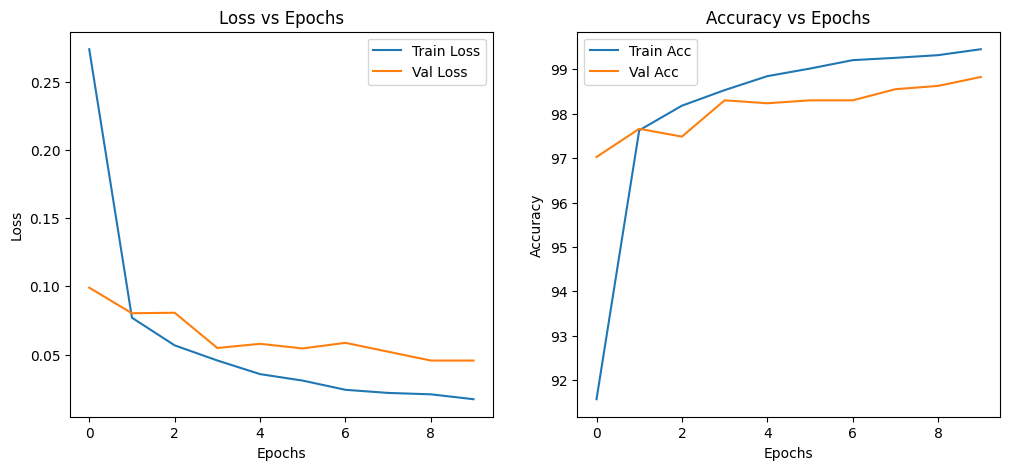

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model.train_losses , label="Train Loss")
plt.plot(model.val_losses , label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.subplot(1,2,2)
plt.plot(model.train_accuracies , label="Train Acc")
plt.plot(model.val_accuracies , label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()